In [32]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import pandas as pd

In [33]:
height = 64
width = 64
desired_frames = 30  
channels = 3

In [34]:
train_dir = 'UCF101/train'
test_dir = 'UCF101/test'

In [35]:
train_csv_path = 'UCF101/train.csv'
train_df = pd.read_csv(train_csv_path)

In [36]:
test_csv_path = 'UCF101/test.csv'
test_df = pd.read_csv(test_csv_path)

In [37]:
train_videos = []
train_labels = []
test_videos = []
test_labels = []

In [38]:
def preprocess_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (height, width))
        frame = frame / 255.0
        frames.append(frame)
    cap.release()
    if len(frames) < desired_frames:
        frames.extend([np.zeros((height, width, channels)) for _ in range(desired_frames - len(frames))])
    elif len(frames) > desired_frames:
        frames = frames[:desired_frames]
    return frames

In [39]:
label_map = {}
next_label = 0
for index, row in train_df.iterrows():
    video_path = os.path.join(train_dir, row['video_name'])
    frames = preprocess_video(video_path)
    train_videos.append(frames)
    label = row['tag']
    if label not in label_map:
        label_map[label] = next_label
        next_label += 1
    train_labels.append(label_map[label])

In [40]:
for index, row in test_df.iterrows():
    video_path = os.path.join(test_dir, row['video_name'])
    frames = preprocess_video(video_path)
    test_videos.append(frames)
    label = row['tag']
    if label not in label_map:
        label_map[label] = next_label
        next_label += 1
    test_labels.append(label_map[label])

In [41]:
train_videos = np.array(train_videos)
train_labels = np.array(train_labels)
test_videos = np.array(test_videos)
test_labels = np.array(test_labels)

In [42]:
model = Sequential([
    Conv3D(64, kernel_size=(3, 3, 3), activation='relu', input_shape=(desired_frames, height, width, channels)),
    MaxPooling3D(pool_size=(2, 2, 2)),
    Conv3D(128, kernel_size=(3, 3, 3), activation='relu'),
    MaxPooling3D(pool_size=(2, 2, 2)),
    Conv3D(256, kernel_size=(3, 3, 3), activation='relu'),
    MaxPooling3D(pool_size=(2, 2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

In [43]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [44]:
history = model.fit(train_videos, train_labels, epochs=10, validation_data=(test_videos, test_labels))

Epoch 1/10
19/19 [==============================] - 53s 3s/step - loss: 1.8757 - accuracy: 0.2626 - val_loss: 1.4306 - val_accuracy: 0.2723
Epoch 2/10
19/19 [==============================] - 47s 2s/step - loss: 1.1587 - accuracy: 0.5438 - val_loss: 1.0912 - val_accuracy: 0.5536
Epoch 3/10
19/19 [==============================] - 52s 3s/step - loss: 0.6497 - accuracy: 0.7407 - val_loss: 0.9582 - val_accuracy: 0.6295
Epoch 4/10
19/19 [==============================] - 59s 3s/step - loss: 0.3687 - accuracy: 0.8603 - val_loss: 1.0647 - val_accuracy: 0.5893
Epoch 5/10
19/19 [==============================] - 50s 3s/step - loss: 0.2239 - accuracy: 0.9327 - val_loss: 1.2943 - val_accuracy: 0.5625
Epoch 6/10
19/19 [==============================] - 47s 2s/step - loss: 0.2333 - accuracy: 0.9158 - val_loss: 1.7624 - val_accuracy: 0.5580
Epoch 7/10
19/19 [==============================] - 47s 2s/step - loss: 0.1078 - accuracy: 0.9646 - val_loss: 0.9461 - val_accuracy: 0.6607
Epoch 8/10
19/19 [==

In [45]:
test_loss, test_acc = model.evaluate(test_videos, test_labels)
print(f'Test accuracy: {test_acc}')

7/7 [==============================] - 5s 701ms/step - loss: 1.9731 - accuracy: 0.5982
Test accuracy: 0.5982142686843872


In [46]:
predictions = model.predict(test_videos)

7/7 [==============================] - 5s 668ms/step


In [47]:
reverse_label_map = {v: k for k, v in label_map.items()}

predicted_labels = np.argmax(predictions, axis=1)

for i in range(len(test_labels)):
    predicted_label_name = reverse_label_map[predicted_labels[i]]
    true_label_name = reverse_label_map[test_labels[i]]
    print(f"Predicted label: {predicted_label_name}, True label: {true_label_name}")


Predicted label: CricketShot, True label: CricketShot
Predicted label: CricketShot, True label: CricketShot
Predicted label: CricketShot, True label: CricketShot
Predicted label: CricketShot, True label: CricketShot
Predicted label: CricketShot, True label: CricketShot
Predicted label: CricketShot, True label: CricketShot
Predicted label: CricketShot, True label: CricketShot
Predicted label: TennisSwing, True label: CricketShot
Predicted label: TennisSwing, True label: CricketShot
Predicted label: TennisSwing, True label: CricketShot
Predicted label: TennisSwing, True label: CricketShot
Predicted label: TennisSwing, True label: CricketShot
Predicted label: TennisSwing, True label: CricketShot
Predicted label: TennisSwing, True label: CricketShot
Predicted label: CricketShot, True label: CricketShot
Predicted label: CricketShot, True label: CricketShot
Predicted label: CricketShot, True label: CricketShot
Predicted label: TennisSwing, True label: CricketShot
Predicted label: CricketShot

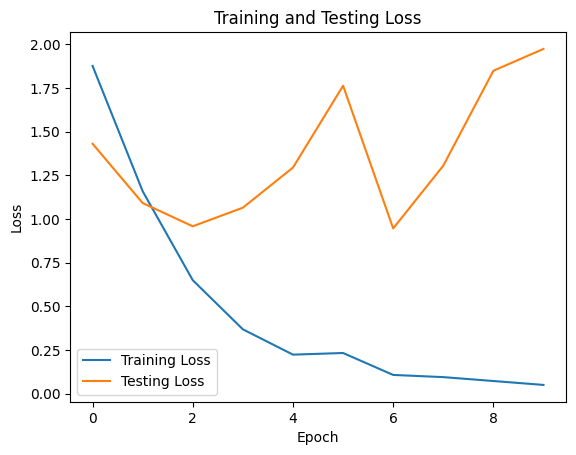

In [48]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss')
plt.show()

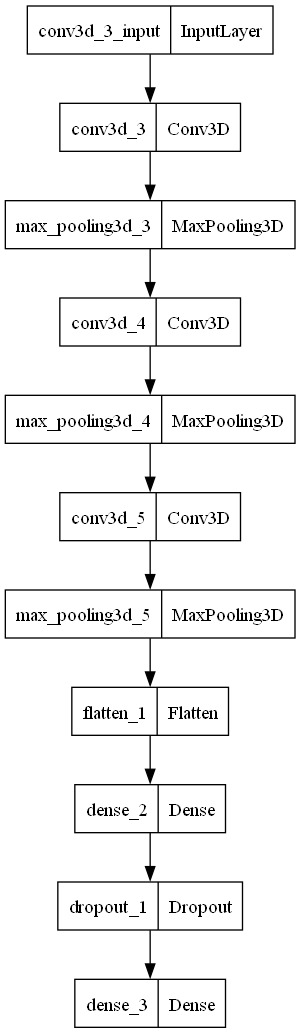

In [49]:
import pydot
from keras.utils import plot_model
plot_model(model, to_file = 'cnn_video.png')